In [3]:
import pandas as pd
import numpy as np
from intervaltree import IntervalTree
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import os

In [4]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [ ]:
def load_and_process_data(peaks_file: str, dexseq_file: str, padj_threshold: float = 0.05) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and process the peaks and DEXSeq data files.
    
    Args:
        peaks_file: Path to peaks CSV file
        dexseq_file: Path to DEXSeq results CSV file
        padj_threshold: Adjusted p-value threshold for significance
    
    Returns:
        Tuple of processed peaks and DEXSeq DataFrames
    """
    # Load data
    peaks_df = pd.read_csv(peaks_file)
    dexseq_df = pd.read_csv(dexseq_file)
    
    # Filter significant DEXSeq results
    dexseq_df = dexseq_df[dexseq_df['padj'] < padj_threshold].copy()
    
    return peaks_df, dexseq_df

In [ ]:

def create_interval_tree(peaks_df: pd.DataFrame) -> IntervalTree:
    """
    Create an interval tree from peaks data for efficient overlap detection.
    """
    tree = IntervalTree()
    for _, row in peaks_df.iterrows():
        tree.addi(row['start'], row['end'], {
            'seqnames': row['seqnames'],
            'peak_id': row.name,
            'peak_name': row['peak_name']
        })
    return tree

In [ ]:
def find_overlaps(dexseq_df: pd.DataFrame, peaks_tree: IntervalTree) -> List[dict]:
    """
    Find overlaps between DEXSeq exons and peaks.
    """
    overlaps = []
    
    for _, exon in dexseq_df.iterrows():
        chr_name = exon['genomicData.seqnames']
        start = exon['genomicData.start']
        end = exon['genomicData.end']
        
        # Find overlapping peaks
        overlapping = peaks_tree.overlap(start, end)
        
        for overlap in overlapping:
            if overlap.data['seqnames'] == chr_name:
                overlaps.append({
                    'exon_id': exon['featureID'],
                    'peak_id': overlap.data['peak_id'],
                    'peak_name': overlap.data['peak_name'],
                    'dexseq_name': exon['dexseq_name'],
                    'chromosome': chr_name,
                    'overlap_start': max(start, overlap.begin),
                    'overlap_end': min(end, overlap.end),
                    'overlap_length': min(end, overlap.end) - max(start, overlap.begin),
                    'exon_log2fc': exon['log2fold_treated_control'],
                    'exon_padj': exon['padj']
                })
    
    return overlaps

In [97]:
def plot_overlap_lengths(overlaps_df: pd.DataFrame, ax):
    """Plot distribution of overlap lengths."""
    sns.histplot(data=overlaps_df, x='overlap_length', bins=30, ax=ax)
    ax.set_title('Distribution of Overlap Lengths')
    ax.set_xlabel('Overlap Length (bp)')

def plot_fc_correlation(overlaps_df: pd.DataFrame, peaks_df: pd.DataFrame, ax):
    """Plot correlation between exon and peak fold changes."""
    peak_fc = peaks_df.loc[overlaps_df['peak_id']]['L2FC'].values
    sns.scatterplot(data=overlaps_df, x='exon_log2fc', y=peak_fc, ax=ax)
    ax.set_title('Exon Log2FC vs Peak Log2FC')
    ax.set_xlabel('Exon Log2FC')
    ax.set_ylabel('Peak Log2FC')
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

def plot_chromosome_distribution(overlaps_df: pd.DataFrame, ax):
    """Plot distribution of overlaps across chromosomes."""
    overlaps_df['chromosome'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title('Overlaps by Chromosome')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Number of Overlaps')

def visualize_overlaps(overlaps_df: pd.DataFrame, peaks_df: pd.DataFrame, dexseq_df: pd.DataFrame):
    """
    Create visualizations for the overlap analysis.
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # 1. Distribution of overlap lengths
    ax1 = fig.add_subplot(gs[0, 0])
    plot_overlap_lengths(overlaps_df, ax1)
    
    # 2. Scatter plot of exon log2FC vs peak fold change
    ax2 = fig.add_subplot(gs[0, 1])
    plot_fc_correlation(overlaps_df, peaks_df, ax2)
    
    # 3. Chromosome distribution of overlaps
    ax3 = fig.add_subplot(gs[1, 0])
    plot_chromosome_distribution(overlaps_df, ax3)
    
    plt.tight_layout()
    return fig

In [84]:
# Example usage
peaks_file = "./DATA/Peak.csv"
dexseq_file = "./output/dexseq_results_PW1_vs_combined_controls_cleaned.csv"
output_prefix = "./output/overlap_analysis"

# overlaps_df = main(peaks_file, dexseq_file, output_prefix)

In [85]:
# Load and process data
peaks_df, dexseq_df = load_and_process_data(peaks_file, dexseq_file)

In [113]:
pd.set_option('display.max_columns', None)
peaks_df.head()

,peak_name,seqnames,start,end,width,annotation,geneChr,geneStart,geneEnd,geneLength,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,ASE1,ASE2,GeneID,Ctrl.bam,V5.bam,difference,FC,L2FC
0,chr15:25051475-25051745,chr15,25051475.0,25051745.0,271.0,Promoter (<=1kb),15.0,25051477.0,25051571.0,95.0,100033413.0,ENST00000384335.1,0.0,ENSG00000207063,SNORD116-1,"small nucleolar RNA, C/D box 116-1",NaN,NaN,controlledV5_peak_329,0,961,961,961.0,9.908392621
1,chr2:74154059-74154316,chr2,74154059.0,74154316.0,258.0,3' UTR,2.0,74148079.0,74151952.0,3874.0,100507171.0,ENST00000656407.1,5980.0,ENSG00000225439,BOLA3-DT,BOLA3 divergent transcript,NaN,NaN,controlledV5_peak_575,0,31,31,31.0,4.95419631
2,chr17:21198291-21198758,chr17,21198291.0,21198758.0,468.0,3' UTR,17.0,21184385.0,21193265.0,8881.0,25979.0,ENST00000581463.1,13906.0,ENSG00000109016,DHRS7B,dehydrogenase/reductase 7B,NaN,NaN,controlledV5_peak_423,0,20,20,20.0,4.321928095
3,chr17:744815-745029,chr17,744815.0,745029.0,215.0,3' UTR,17.0,747844.0,752038.0,4195.0,50628.0,ENST00000574958.1,7009.0,ENSG00000179409,GEMIN4,gem nuclear organelle associated protein 4,NaN,NaN,controlledV5_peak_403,0,18,18,18.0,4.169925001
4,chr10:27134830-27135032,chr10,27134830.0,27135032.0,203.0,Promoter (1-2kb),10.0,27123547.0,27136337.0,12791.0,10730.0,ENST00000463270.1,1305.0,ENSG00000136758,YME1L1,YME1 like 1 ATPase,NaN,NaN,controlledV5_peak_142,0,17,17,17.0,4.087462841


In [87]:
peaks_df = peaks_df.rename(columns={"Row.names": "peak_name"})

In [88]:
print(list(peaks_df['seqnames'][:5]))
print(list(peaks_df.iloc[:5].index))

['chr15', 'chr2', 'chr17', 'chr17', 'chr10']
[0, 1, 2, 3, 4]


In [114]:
dexseq_df.head()

,dexseq_name,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.14:E001,ENSG00000000003.14,E001,120.179059,0.011335,2984.629607,0.000000e+00,0.000000e+00,16.638651,14.784409,-0.479628,chrX,100627109,100628669,1561,-,123,139,86,83,106,98,119,182,189
1,ENSG00000000003.14:E002,ENSG00000000003.14,E002,1270.531715,0.006461,396.260920,8.975001e-87,1.213046e-86,30.813401,30.602511,-0.045605,chrX,100628670,100629986,1317,-,1007,1237,687,906,1184,974,1419,2630,2220
2,ENSG00000000003.14:E003,ENSG00000000003.14,E003,444.716283,0.008585,1806.024855,0.000000e+00,0.000000e+00,23.933712,23.706313,-0.051117,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.14:E004,ENSG00000000003.14,E004,1.981576,0.022925,3109.695893,0.000000e+00,0.000000e+00,2.492781,2.656301,0.185495,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.14:E005,ENSG00000000003.14,E005,358.929210,0.007125,2538.819848,0.000000e+00,0.000000e+00,22.574929,22.337963,-0.053991,chrX,100632485,100632568,84,-,289,347,196,233,334,297,393,719,654


In [90]:
dexseq_df = dexseq_df.rename(columns={"Unnamed: 0": "dexseq_name"})

In [91]:
dexseq_df.columns

Index(['dexseq_name', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3'],
      dtype='object')

In [92]:
print(list(dexseq_df['genomicData.seqnames'][:5]))
print(list(dexseq_df['featureID'][:5]))


['chrX', 'chrX', 'chrX', 'chrX', 'chrX']
['E001', 'E002', 'E003', 'E004', 'E005']


In [93]:
# Create interval tree for efficient overlap detection
peaks_tree = create_interval_tree(peaks_df)

In [94]:
list(peaks_tree.items())[:10]



[Interval(44065741.0, 44065975.0, {'seqnames': 'chr2', 'peak_id': 691, 'peak_name': 'chr2:44065741-44065975'}),
 Interval(2431546.0, 2431734.0, {'seqnames': 'chr19', 'peak_id': 619, 'peak_name': 'chr19:2431546-2431734'}),
 Interval(75321808.0, 75322308.0, {'seqnames': 'chr15', 'peak_id': 1085, 'peak_name': 'chr15:75321808-75322308'}),
 Interval(253490.0, 253707.0, {'seqnames': 'chr10', 'peak_id': 37, 'peak_name': 'chr10:253490-253707'}),
 Interval(47783878.0, 47784227.0, {'seqnames': 'chr12', 'peak_id': 389, 'peak_name': 'chr12:47783878-47784227'}),
 Interval(41604043.0, 41604252.0, {'seqnames': 'chr22', 'peak_id': 785, 'peak_name': 'chr22:41604043-41604252'}),
 Interval(1787781.0, 1788035.0, {'seqnames': 'chr16', 'peak_id': 718, 'peak_name': 'chr16:1787781-1788035'}),
 Interval(19378387.0, 19378889.0, {'seqnames': 'chr9', 'peak_id': 1063, 'peak_name': 'chr9:19378387-19378889'}),
 Interval(37925659.0, 37925853.0, {'seqnames': 'chr22', 'peak_id': 449, 'peak_name': 'chr22:37925659-379258

In [95]:
# Find overlaps
overlaps = find_overlaps(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [96]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,overlap_start,overlap_end,overlap_length,exon_log2fc,exon_padj
0,E007,474,chr17:47132254-47132464,ENSG00000004897.12:E007,chr17,47132257.0,47132374.0,117.0,-0.094016,0.000000e+00
1,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,57428714.0,57428937.0,223.0,-0.207524,0.000000e+00
2,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,57428938.0,57428958.0,20.0,-0.248556,0.000000e+00
3,E011,160,chr7:107160282-107160602,ENSG00000005249.13:E011,chr7,107160282.0,107160602.0,320.0,-0.141606,4.551355e-23
4,E031,395,chr16:3850321-3850506,ENSG00000005339.14:E031,chr16,3850321.0,3850506.0,185.0,0.036842,7.307589e-206


In [69]:
overlaps_df.shape

(1049, 8)

In [70]:
# Save overlaps to file
overlaps_df.to_csv(f"{output_prefix}_overlaps.csv", index=False)

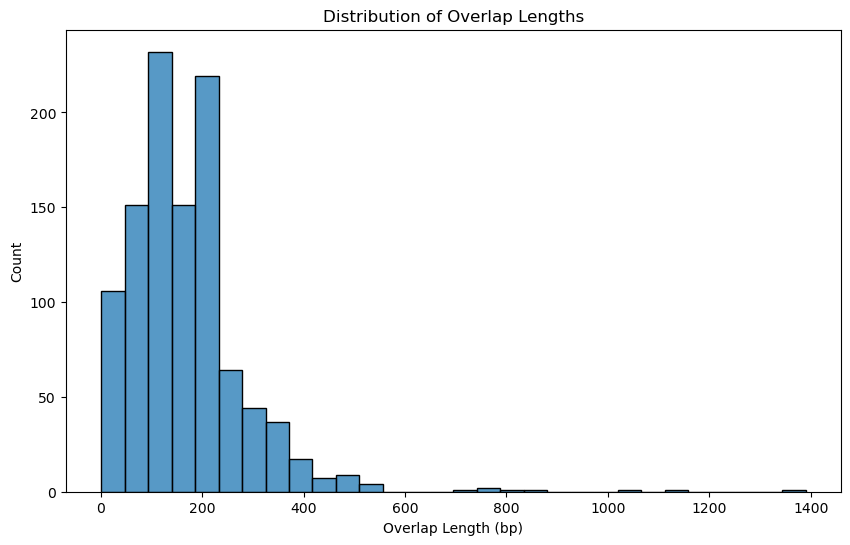

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_overlap_lengths(overlaps_df, ax)


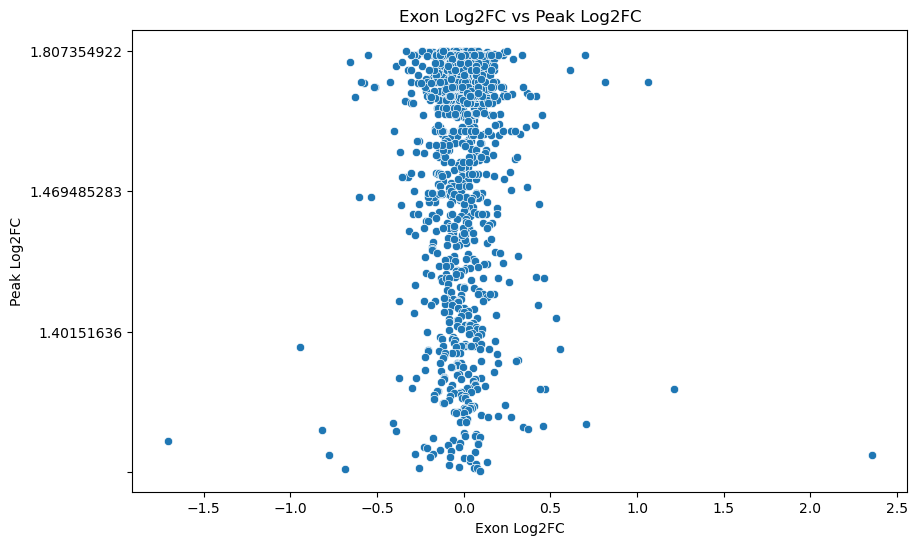

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_fc_correlation(overlaps_df, peaks_df, ax)

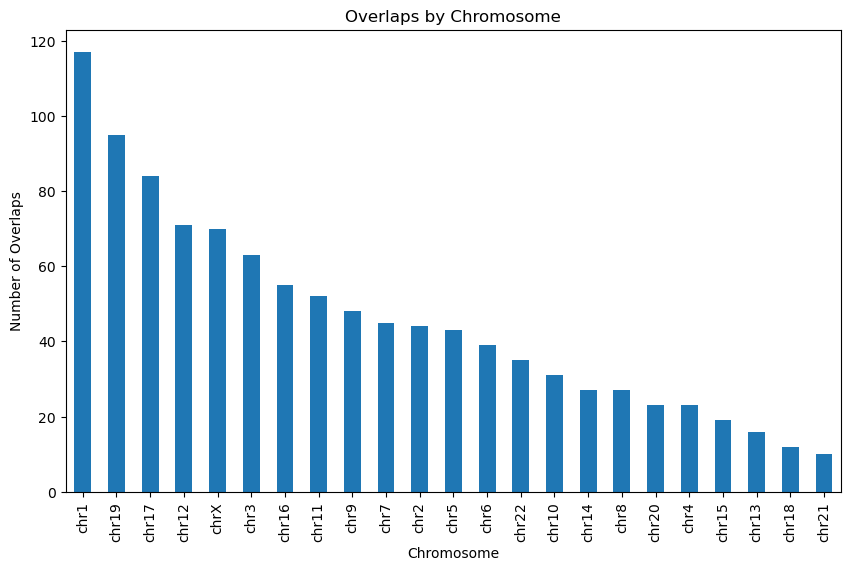

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_chromosome_distribution(overlaps_df, ax)

In [77]:
total_peaks = len(peaks_df)
total_exons = len(dexseq_df)
peaks_with_overlaps = len(overlaps_df['peak_id'].unique())
exons_with_overlaps = len(overlaps_df['exon_id'].unique())

print(f"Total Peaks: {total_peaks}")
print(f"Total Diff. Expressed Exons: {total_exons}")
print(f"Peaks with Overlaps: {peaks_with_overlaps}")
print(f"Exons with Overlaps: {exons_with_overlaps}")
print(f"Total Overlap Events: {len(overlaps_df)}")

Total Peaks: 1136
Total Diff. Expressed Exons: 267114
Peaks with Overlaps: 743
Exons with Overlaps: 70
Total Overlap Events: 1049


In [108]:
def find_overlaps2(dexseq_df: pd.DataFrame, peaks_tree: IntervalTree) -> List[dict]:
    """
    Find overlaps and nearby peaks for DEXSeq exons.
    Also calculates distance to nearest peak for non-overlapping cases.
    """
    results = []
    
    for index, exon in dexseq_df.iterrows():
        chr_name = exon['genomicData.seqnames']
        exon_start = exon['genomicData.start']
        exon_end = exon['genomicData.end']
        exon_center = (exon_start + exon_end) / 2
        
        # Extend search window by 10kb in each direction
        search_start = exon_start - 10000
        search_end = exon_end + 10000
        
        # Find peaks in extended window
        nearby = peaks_tree.overlap(search_start, search_end)
        if index == 0 and len(nearby) > 0:
            print(list(nearby))
        
        for peak in nearby:
            if peak.data['seqnames'] == chr_name:
                peak_center = (peak.begin + peak.end) / 2
                
                # Calculate distance (negative if peak is upstream, positive if downstream)
                distance = peak_center - exon_center
                
                # Calculate overlap (if any)
                overlap_start = max(exon_start, peak.begin)
                overlap_end = min(exon_end, peak.end)
                overlap_length = max(0, overlap_end - overlap_start)
                
                results.append({
                    'exon_id': exon['featureID'],
                    'peak_id': peak.data['peak_id'],
                    'peak_name': peak.data['peak_name'],
                    'dexseq_name': exon['dexseq_name'],
                    'chromosome': chr_name,
                    'distance_to_peak': distance,
                    'overlap_length': overlap_length,
                    'exon_log2fc': exon['log2fold_treated_control'],
                    'exon_padj': exon['padj']
                })
    
    return results

def plot_distance_vs_fc(overlaps_df: pd.DataFrame, ax):
    """Plot relationship between peak distance and exon fold change."""
    # Convert distance to kb for better visualization
    overlaps_df['distance_kb'] = overlaps_df['distance_to_peak'] / 1000
    
    # Create scatter plot
    sns.scatterplot(
        data=overlaps_df,
        x='distance_kb',
        y='exon_log2fc',
        alpha=0.5,
        ax=ax
    )
    
    # Add trend line
    sns.regplot(
        data=overlaps_df,
        x='distance_kb',
        y='exon_log2fc',
        scatter=False,
        color='red',
        ax=ax
    )
    
    ax.set_title('Exon Log2FC vs Distance to Peak')
    ax.set_xlabel('Distance to Peak (kb)')
    ax.set_ylabel('Exon Log2FC')
    
    # Add vertical line at x=0 to mark the exon position
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add horizontal line at y=0 to mark no change in expression
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

def visualize_distance_analysis(overlaps_df: pd.DataFrame):
    """
    Create visualizations for the distance analysis.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Distance vs Fold Change scatter plot
    plot_distance_vs_fc(overlaps_df, ax1)
    
    # 2. Distribution of distances
    sns.histplot(
        data=overlaps_df,
        x='distance_to_peak',
        bins=50,
        ax=ax2
    )
    ax2.set_title('Distribution of Peak Distances')
    ax2.set_xlabel('Distance to Peak (bp)')
    
    plt.tight_layout()
    return fig

In [110]:
# # Find overlaps and distances
overlaps = find_overlaps2(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [111]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb
0,E001,641,chr2:37222376-37222562,ENSG00000003509.16:E001,chr2,-9199.0,0.0,-0.042174,0.0,-9.1990
1,E002,641,chr2:37222376-37222562,ENSG00000003509.16:E002,chr2,-9250.5,0.0,0.121151,0.0,-9.2505
2,E003,641,chr2:37222376-37222562,ENSG00000003509.16:E003,chr2,-9717.0,0.0,0.211989,0.0,-9.7170
3,E004,474,chr17:47132254-47132464,ENSG00000004897.12:E004,chr17,9837.0,0.0,-0.079177,0.0,9.8370
4,E005,474,chr17:47132254-47132464,ENSG00000004897.12:E005,chr17,8436.0,0.0,-0.102252,0.0,8.4360


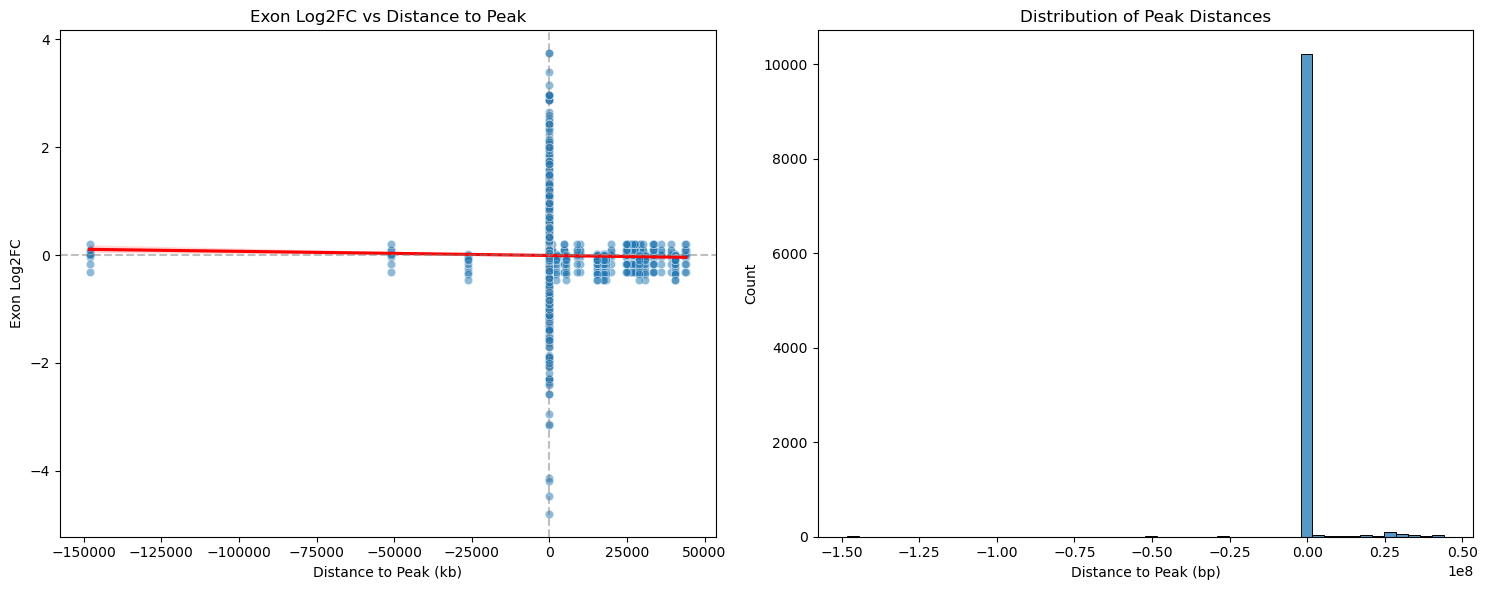

In [112]:
# Create visualization
fig = visualize_distance_analysis(overlaps_df)
plt.show()